Processing all data files...
  - Processed S01R01.txt
  - Processed S01R02.txt
  - Processed S02R01.txt
  - Processed S02R02.txt
  - Processed S03R01.txt
  - Processed S03R02.txt
  - Processed S03R03.txt
  - Processed S04R01.txt
  - Processed S05R01.txt
  - Processed S05R02.txt
  - Processed S06R01.txt
  - Processed S06R02.txt
  - Processed S07R01.txt
  - Processed S07R02.txt
  - Processed S08R01.txt
  - Processed S09R01.txt
  - Processed S10R01.txt

Data aggregation complete.
Shape of the master DataFrame: (17808, 46)
Distribution of Labels in the full dataset:
Label
1    16087
2     1721
Name: count, dtype: int64

Data split into training and testing sets:
Original Training set shape: (14246, 45)
Original Testing set shape: (3562, 45)

Applying SMOTE to the training data...
SMOTE complete.
Original training label distribution: {1: 12869, 2: 1377}
Resampled training label distribution: {2: 12869, 1: 12869}

Training the RandomForest model on resampled data...
Model training complete.


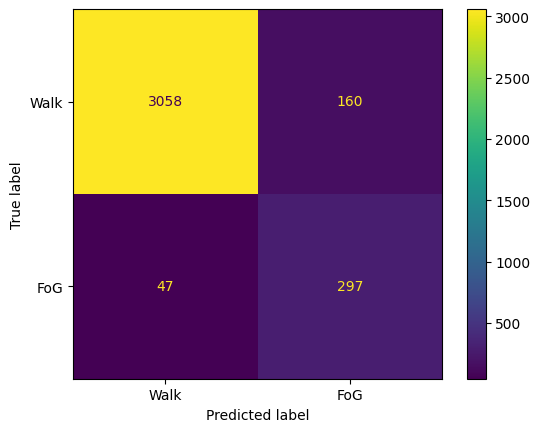


Champion model saved to: ../models/fog_detection_random_forest.joblib


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import custom processing function
import sys
sys.path.append('../')
from src.data_processing import process_file_to_features

# Machine Learning imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE # Import SMOTE

# --- 1. DATA AGGREGATION ---
raw_data_path = '../data/raw/'
all_files = [f for f in os.listdir(raw_data_path) if f.endswith('.txt')]
list_of_dfs = []

print("Processing all data files...")
for file in all_files:
    file_path = os.path.join(raw_data_path, file)
    processed_df = process_file_to_features(file_path)
    list_of_dfs.append(processed_df)
    print(f"  - Processed {file}")

master_df = pd.concat(list_of_dfs, ignore_index=True)

print("\nData aggregation complete.")
print("Shape of the master DataFrame:", master_df.shape)
print("Distribution of Labels in the full dataset:")
print(master_df['Label'].value_counts())

# --- 2. MODEL PREPARATION ---
X = master_df.drop('Label', axis=1)
y = master_df['Label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nData split into training and testing sets:")
print("Original Training set shape:", X_train.shape)
print("Original Testing set shape:", X_test.shape)

# --- 3. APPLY SMOTE ---
# Handle class imbalance by creating synthetic samples for the minority class
print("\nApplying SMOTE to the training data...")
smote = SMOTE(random_state=42)

# IMPORTANT: Apply SMOTE only to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("SMOTE complete.")
print("Original training label distribution:", y_train.value_counts().to_dict())
print("Resampled training label distribution:", y_train_resampled.value_counts().to_dict())


# --- 4. MODEL TRAINING ---
# Initialize the RandomForestClassifier
# We can remove class_weight='balanced' now as SMOTE handles the balancing
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

print("\nTraining the RandomForest model on resampled data...")
# Train the model on the RESAMPLED training data
model.fit(X_train_resampled, y_train_resampled)
print("Model training complete.")


# --- 5. MODEL EVALUATION ---
print("\nEvaluating model performance on the original test set...")
# Make predictions on the original, untouched test data
y_pred = model.predict(X_test)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Walk (1)', 'FoG (2)']))

# Display the confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Walk', 'FoG'])
disp.plot()
plt.show()


# --- 6. SAVE THE CHAMPION MODEL ---
import joblib

# Ensure the models directory exists
os.makedirs('../models', exist_ok=True)

# Save the trained model to the models directory
model_filename = '../models/fog_detection_random_forest.joblib'
joblib.dump(model, model_filename)

print(f"\nChampion model saved to: {model_filename}")